#  --------------------------------------Deep Face Detection------------------------------------------

# Part one: Preprocessing

### **1** Install & Import Dependencies

In [ ]:
!pip install opencv-python albumentations labelme

In [18]:
import os
import time
import uuid
import cv2

### 2 Image Collection with OpenCV

In [11]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 33

In [17]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF ==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

### 3 Annotate Images with LabelMe

In [19]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\e182001\.labelmerc


### 4 Image loading function

* Import dependencies

In [20]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

* Load image into TF Data Pipeline

In [45]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True)

In [46]:
images.as_numpy_iterator().next()

b'data\\images\\914ee239-3ae6-11ed-afe7-f4b301d62f1c.jpg'

In [47]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [48]:
images = images.map(load_image)

In [49]:
images.as_numpy_iterator().next()

array([[[102, 100,  87],
        [ 97,  95,  82],
        [ 93,  90,  75],
        ...,
        [151, 148, 139],
        [148, 148, 136],
        [146, 146, 134]],

       [[100,  96,  84],
        [ 99,  96,  81],
        [ 99,  96,  81],
        ...,
        [149, 146, 137],
        [148, 146, 134],
        [144, 144, 132]],

       [[100,  94,  80],
        [102,  96,  82],
        [104,  98,  84],
        ...,
        [149, 146, 137],
        [149, 146, 137],
        [148, 145, 136]],

       ...,

       [[  5,  10,   6],
        [  6,  11,   7],
        [  6,  11,   7],
        ...,
        [210, 215, 209],
        [210, 215, 209],
        [210, 215, 209]],

       [[  5,  10,   6],
        [  6,  11,   7],
        [  7,  12,   8],
        ...,
        [209, 214, 208],
        [209, 214, 208],
        [209, 214, 208]],

       [[  5,  10,   6],
        [  6,  11,   7],
        [  8,  13,   9],
        ...,
        [208, 213, 207],
        [208, 213, 207],
        [209, 214, 208]]

In [50]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

View Raw Images with Matplotlib

In [59]:
image_generator=images.batch(5).as_numpy_iterator()

In [60]:
plot_images = image_generator.next()

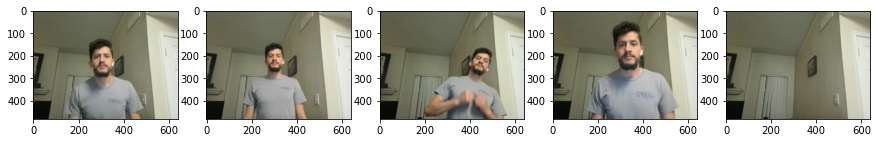

In [61]:
fig, ax = plt.subplots(ncols=5, figsize=(15,15))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()    

* Create three folders train, test, val
* create in each one of them two folders named images and labels
* move the images manually by giving 70%, 20%, 10% to train, test, val accordingly

### 5. Partition Unaugmented Data

* Move the Matching labels

In [62]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### 6. Apply Image Augmentation on our images and labels using ALBUMENTATIONS

In [66]:
import albumentations as alb

In [72]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [89]:
img = cv2.imread(os.path.join('data', 'train', 'images', '500bab4f-3ae6-11ed-87db-f4b301d62f1c.jpg'))

In [90]:
with open(os.path.join('data', 'train', 'labels', '500bab4f-3ae6-11ed-87db-f4b301d62f1c.json'), 'r') as f:
    label =json.load(f)

In [91]:
label['shapes'][0]['points']

[[249.45833333333337, 105.20833333333334],
 [403.1041666666667, 316.14583333333337]]

* Extract coordinates and Rescale to Match Image Resolution

In [92]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [93]:
coords

[249.45833333333337, 105.20833333333334, 403.1041666666667, 316.14583333333337]

In [94]:
coords = list(np.divide(coords,[640,480,640,480]))
coords

[0.3897786458333334,
 0.2191840277777778,
 0.6298502604166667,
 0.6586371527777779]

* Apply Augmentation 

In [95]:
augmented = augmentor(image=img , bboxes=[coords],class_labels=['face'])

In [99]:
augmented['bboxes'][0][2:]

(0.7180092592592593, 0.6758796296296297)

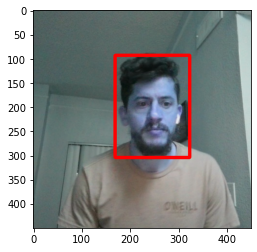

In [103]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build the Augmentation Pipeline

In [104]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(20):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.77470703125, 0.3786892361111111, 0.5704427083333334, 0.6108940972222222, 'face'].
x_max is less than or equal to x_min for bbox [0.57451171875, 0.5457899305555556, 0.4125651041666667, 0.25390625, 'face'].
x_max is less than or equal to x_min for bbox [0.6632161458333334, 0.2907986111111111, 0.4556966145833334, 0.5859375, 'face'].
x_max is less than or equal to x_min for bbox [0.5671875, 0.2918836805555556, 0.3922200520833334, 0.6575520833333334, 'face'].
x_max is less than or equal to x_min for bbox [0.5509114583333334, 0.6032986111111112, 0.371875, 0.25390625, 'face'].
x_max is less than or equal to x_min for bbox [0.6485677083333334, 0.6282552083333334, 0.4784830729166667, 0.3483072916666667, 'face'].
x_max is less than or equal to x_min for bbox [0.6021809895833334, 0.597873263888889, 0.4483723958333334, 0.3255208333333333, 'face'].
x_max is less than or equal to x_min for bbox [0.8609700520833334, 0.5045572916666666, 0.63961588541666

* Load Aumented images to Tensorflow Dataset

In [120]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [121]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [122]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# Build labels loading function

In [123]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

* Load our labels to Tensorflow Dataset

In [127]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [128]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [129]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### Combine label and Image samples

* Check the length of our partition

In [132]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images),len(val_labels)

(1180, 1180, 340, 340, 160, 160)

### Create final dataset(Images/Labels)

In [137]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1600)
train = train.batch(8)
train = train.prefetch(4)

In [138]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(460)
test = test.batch(8)
test = test.prefetch(4)

In [139]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(220)
val = val.batch(8)
val = val.prefetch(4)

### Plot View Images and Annotations

In [169]:
data_samples = train.as_numpy_iterator()

In [180]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


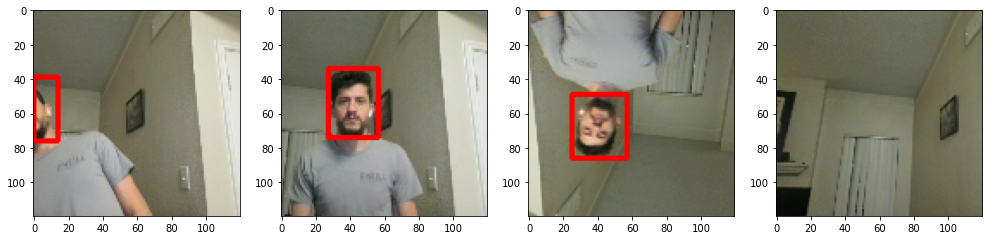

In [181]:
fig, ax = plt.subplots(ncols=4, figsize=(17,17))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Part Two: Build Deep Learning using the Functional API

* I mport layers and Base Network

In [184]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPool2D
from tensorflow.keras.applications import VGG16

* Download VGG16

In [185]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 3s 0us/step


In [186]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

* Build Instance of Network

In [187]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPool2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model Regression Model
    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

* Test out our Neural Network

In [188]:
facetracker = build_model()

In [189]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [190]:
X, y = train.as_numpy_iterator().next()

In [191]:
X.shape

(8, 120, 120, 3)

In [195]:
classes, coords = facetracker.predict(X)

In [196]:
classes, coords

(array([[0.42177507],
        [0.36966655],
        [0.40765035],
        [0.3881895 ],
        [0.4608276 ],
        [0.3396523 ],
        [0.38106522],
        [0.3941808 ]], dtype=float32),
 array([[0.3527804 , 0.44369292, 0.39719188, 0.46433482],
        [0.37922752, 0.43018046, 0.35508928, 0.49462658],
        [0.3875462 , 0.4814622 , 0.3258772 , 0.54887396],
        [0.42775404, 0.5053104 , 0.38672805, 0.5451003 ],
        [0.4249648 , 0.3884974 , 0.35695285, 0.43984786],
        [0.35822943, 0.44530812, 0.35946977, 0.53706187],
        [0.363257  , 0.46194187, 0.35946006, 0.5385823 ],
        [0.44392654, 0.40046585, 0.4253921 , 0.4745366 ]], dtype=float32))

## Define Losses and Optimizers

* Define Optimizer and Learning Rate

In [197]:
len(train)

148

In [199]:
# Define Learning rate decay
batches_per_epoch = len(train)
lr = (1./0.75 -1)/batches_per_epoch # learning rate

In [200]:
# Define Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr)

#### Create Localization loss and Classification loss

In [202]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [204]:
# Classification loss
classloss = tf.keras.losses.BinaryCrossentropy()

# Regression loss
regressloss = localization_loss

## Train our Neural Network

* Create Custom Model Class

In [209]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [210]:
model = FaceTracker(facetracker)

In [236]:
model.compile(opt,classloss, regressloss)

### Train the model

In [212]:
logdir='logs'

In [213]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [214]:
model_hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
148/148 [==============================] - 194s 1s/step - total_loss: 0.4110 - class_loss: 0.0794 - regress_loss: 0.3713 - val_total_loss: 0.3098 - val_class_loss: 0.1021 - val_regress_loss: 0.2587
Epoch 2/10
148/148 [==============================] - 218s 1s/step - total_loss: 0.1015 - class_loss: 0.0151 - regress_loss: 0.0939 - val_total_loss: 0.0429 - val_class_loss: 1.7970e-04 - val_regress_loss: 0.0428
Epoch 3/10
148/148 [==============================] - 212s 1s/step - total_loss: 0.0666 - class_loss: 0.0117 - regress_loss: 0.0608 - val_total_loss: 0.0335 - val_class_loss: 1.8383e-04 - val_regress_loss: 0.0334
Epoch 4/10
148/148 [==============================] - 202s 1s/step - total_loss: 0.0272 - class_loss: 0.0015 - regress_loss: 0.0264 - val_total_loss: 0.0414 - val_class_loss: 0.0035 - val_regress_loss: 0.0396
Epoch 5/10
148/148 [==============================] - 201s 1s/step - total_loss: 0.0146 - class_loss: 6.3134e-04 - regress_loss: 0.0142 - val_total_loss: 0.

### Plot the losses

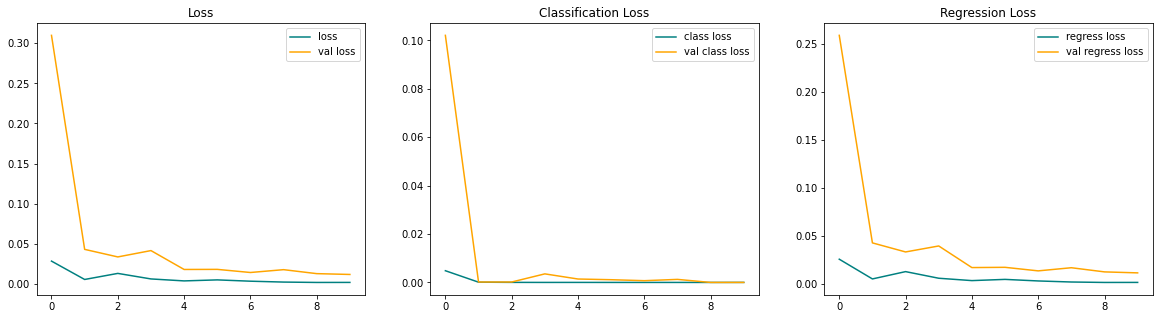

In [219]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(model_hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(model_hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(model_hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(model_hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(model_hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(model_hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
model_hist.evaluate()

# Make Predictions

In [230]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [231]:
y_pred = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


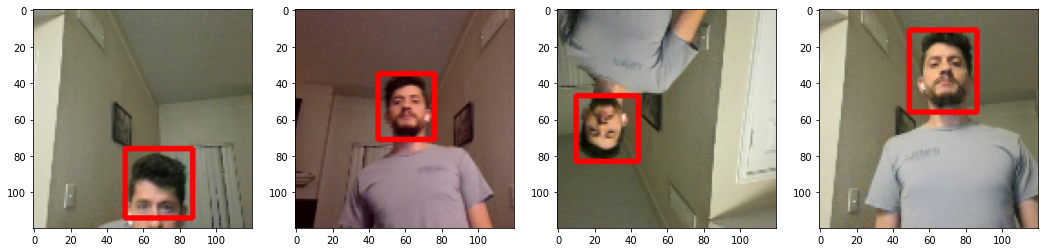

In [232]:
fig, ax = plt.subplots(ncols=4, figsize=(18,18))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    
    if y_pred[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0),
                      2
                     )
        ax[idx].imshow(sample_image)

## Save the Model

In [233]:
from tensorflow.keras.models import load_model

In [241]:
facetracker.save('facetracker.h5')

In [238]:
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()